<a href="https://colab.research.google.com/github/NickPetrilli/AI/blob/main/lab08_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 08
#### By R. Coleman
The goal of this lab is to explore the MNIST data.






### Background
The MNIST dataset is one of the most popular benchmarks for computer vision,
optical character recognition (OCR), etc.
In fact, MNIST is built into TensorFlow.

MNIST comprises thousands of handwritten 0-9 digits that have been digitized as grayscale pixels on fixed-sized panels or cells. The data also contains the corresponding
labels. There is a training set and a testing set.
[Wikipedia](https://en.wikipedia.org/wiki/MNIST_database) gives a list of
published AI methods that have been tested and their accuracies.
Note that convolutional neural netowks (or CNNs) which we cover in a subsequent
lab tend to give the best results.

MNIST centers digits in the cell. However, the centering is inexact, the
insets vary greatly, pixel intensities as well as
the slanting are inconsistent, etc. as you can see in the sample below.

![MNIST sample](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse1.explicit.bing.net%2Fth%3Fid%3DOIP.hWVB-Yr5LcH2lR9t__ZwHQAAAA%26pid%3DApi&f=1&ipt=59fa579bfb9571b29d697a42b8a7745242c08849faafe56cdf4c2f113b44e05e&ipo=images)

Figure 1. MNIST sample

A successful AI will have to deal with these problems.

In this lab, we want to try to find the minimum canvas for a cell.
I asked ChatGPT to write a function for this purpose. Your main task
is to write a function of your own to do the same thing.
It may not be as algorithmically
elegant as ChatGPT but it needs to accomplish the same objective to convey the basic ideas.

However, in the process of carefully reviewing the results, I discovered that ChatGPT made a mistake. The error suggests the reason we **must** be really careful reading codes of others and inspecting results, including those from ChatGPT.

Copy this notebook, study it, and follow the TODOs and instructions to resolve the problem.

At the bottom of this notebook you will find the deliver instructions.

---

### Color theory
This section gives a brief tutorial on color theory which describes one particular encoding of colors.
AI has to deal with color. However, for this lab we are only interested in
the RGB standard.

RGB specifies three channles, red, blue, and green
which in mammalian biology corresponds to distinct RGB visual receptors.
Each channel gives the intensity of the respective color which when combined
with the other channels indicates what we actually see.

For the digital world, the color channel is 8 bits which gives the value in
the range of 0-255. Thus, if color can be represented as (x,y,z) where x, y,
and z represent the intensities of respective RGB components, then there
are 2^24 or roughly 16 million possible colors.
Thus, a color like (255,0,0) is pure red, (0,255,0) is pure
green, and (0,0,255) is pure blue. A color like (255,0,255) is hot pink which
for historical reasons is widely used in game development.
(255,255,255) is white and (0,0,0) is black. (128,128,128) is a middle
shade of gray.

Since all the channels have the same value in grayscale, MNIST needs not three
but one value per pixel. Namely, the value of each pixel is 0-255.





In [1]:
# Step 1: Load the MNIST database
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset -- X_ contains the pixels and y_ the labels
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [2]:
print(f'X_train shape: {X_train.shape} y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape} y_train shape: {y_test.shape}')

X_train shape: (60000, 28, 28) y_train shape: (60000,)
X_test shape: (10000, 28, 28) y_train shape: (10000,)


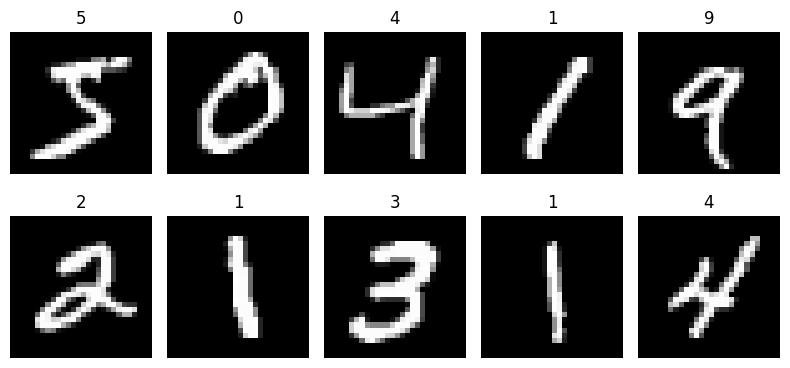

In [3]:
# Step 2: Render the first 10 cells with their labels.
# This is the AI input and output.
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))

for i in range(10):
    # 2x5 grid
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"{y_train[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [4]:
# Step 3: Render the image as characters.
# This is useful so that we can get a better idea of the cell layout.
def renderImage(image):
  # Header row output
  print(f'  ',end='')
  for col in range(image.shape[1]):
    print(f'{col % 10}',end='')
  print(' ')

  # Cell row by row output
  for row in range(image.shape[0]):
    # Row number
    print(f'{row % 10} ',end='')

    # Row
    for col in range(image.shape[1]):
      pixel = image[row,col]
      if pixel != 0:
        pixel = 1
      print(f'{pixel}',end='')
    print('')

In [63]:
# Sample a cell in character output
TRAIN_NO = 1
renderImage(X_train[TRAIN_NO])

  0123456789012345678901234567 
0 0000000000000000000000000000
1 0000000000000000000000000000
2 0000000000000000000000000000
3 0000000000000000000000000000
4 0000000000000001111100000000
5 0000000000000011111100000000
6 0000000000000111111111000000
7 0000000000011111111111000000
8 0000000000011111111111000000
9 0000000000111111111111000000
0 0000000001111111110011100000
1 0000000011111100000011100000
2 0000000111111100000011100000
3 0000000111100000000011100000
4 0000000111000000000011100000
5 0000001111000000000011100000
6 0000001111000000001111100000
7 0000001110000000011111000000
8 0000001110000000111100000000
9 0000001110000001111000000000
0 0000001111111111111000000000
1 0000001111111111100000000000
2 0000001111111110000000000000
3 0000000111111100000000000000
4 0000000000000000000000000000
5 0000000000000000000000000000
6 0000000000000000000000000000
7 0000000000000000000000000000


In [6]:
# Step 4: Study the code below written by ChatGPT to calculate the minimum canvas
# size without pixel=0 padding around the non-zero pixels. Given an image,
# calculate_min_canvas returns the minimum width and height of the canvas.
# ChatGPT prompt: what is a function to calculate the minimum canvas for a given
# MNIST image
import numpy as np

def calculate_min_canvas(image):
    # Find non-zero pixel coordinates (indices) (RC: this is really clever)
    non_zero_pixels = np.argwhere(image > 0)

    # Find the min and max x and y coords of non-zero pixels.
    # axis=0 takes the min, max over all the rows (see below).
    min_x, min_y = np.min(non_zero_pixels, axis=0)
    max_x, max_y = np.max(non_zero_pixels, axis=0)

    # Calculate the width and height of the minimum bounding box
    # width, height is 1-based.
    width = max_x - min_x + 1
    height = max_y - min_y + 1

    return width, height

In [64]:
# The clever part of the above function is the argwhere function.
# As we can see it returns the pixel coordinates where there is a non-zero.
image = X_train[TRAIN_NO]
non_zero_pixels = np.argwhere(image > 0)
# print(non_zero_pixels[0:])
# Need to get the min and max of each column
max_x = np.max(non_zero_pixels[:, 0])
min_x = np.min(non_zero_pixels[:, 0])
max_y = np.max(non_zero_pixels[:, 1])
min_y = np.min(non_zero_pixels[:, 1])

print("max_x: ", max_x, " min_x: ", min_x, " max_y: ", max_y, " min_y: ", min_y)

max_x:  23  min_x:  4  max_y:  22  min_y:  6


In [8]:
# Unit test the function -- it's important that we use TRAIN_NO=1
# because the width and height, in this case, are not the same.
# It should return (20,17), if correct. However, the ChatGPT bug is not
# here; we find it later as we'll see.
calculate_min_canvas(image)

(20, 17)

In [20]:
# Step 5: TODO write a YOUR calculate_min_canvas function; it does the same
# thing functionally as the above ChatGPT function except YOURS does NOT use numpy
# methods.
import math

def calculate_min_canvas(image):
    # Initialize min variables to the largest possible value of image
    # image[0] used in case the image isn't a square (which it is)
    min_x = len(image)
    max_x = -1
    min_y = len(image[0])
    max_y = -1

    # Loop through the x and y axes to find the min and max values
    for x in range(len(image)):
      for y in range(len(image[x])):
        if image[x][y] > 0:
          min_x = min(x, min_x)
          max_x = max(x, max_x)
          min_y = min(y, min_y)
          max_y = max(y, max_y)

    width = max_x - min_x + 1
    height = max_y - min_y + 1

    return width, height

In [10]:
# Unit test your function.
# You should get same results as ChatGPT.
calculate_min_canvas(image)

(20, 17)

In [ ]:
# Step 6: Test the minimum canvas function by cropping the image.
# ChatGPT prompt: write function to crop an image accordingly
!pip install Pillow

In [52]:
# Step 6A: Actual code written by the above ChatGPT prompt...
from PIL import Image

def crop_image(image, canvas_width, canvas_height):
    # Convert numpy array to PIL Image
    image_pil = Image.fromarray(image)

    # Calculate the coordinates to crop the image
    # RC: integer division is always suspicious
    # left = (image.shape[1] - canvas_width) // 2
    # upper = (image.shape[0] - canvas_height) // 2

    # right = left + canvas_width
    # lower = upper + canvas_height

    non_zero_pixels = np.argwhere(image > 0)
    left = np.min(non_zero_pixels[:, 1])  # Finds left-most non-zero pixel
    upper = np.min(non_zero_pixels[:, 0]) # Finds upper-most non-zero pixel

    # right = np.max(non_zero_pixels[:, 0])
    # lower = np.max(non_zero_pixels[:, 1])

    right = np.max(non_zero_pixels[:, 0])
    lower = upper + np.max(non_zero_pixels[:, 1])

    print("left: ", left, "upper: ", upper, "right: ", right, "lower: ", lower)

    # Crop the image
    cropped_image_pil = image_pil.crop((left, upper, right, lower))

    # Convert the cropped PIL Image back to numpy array
    cropped_image = np.array(cropped_image_pil)

    return cropped_image

In [12]:
# Step 7: Render the cropped image.
# Code also written by ChatGPT.
def renderImagePlot(image):
  canvas_width, canvas_height = calculate_min_canvas(image)

  cropped_image = crop_image(image, canvas_width, canvas_height)    # chatGPT

  print(f'Original:')
  renderImage(image)

  print(f'Cropped:')
  renderImage(cropped_image)

  # Display the original and cropped images for comparison
  plt.figure(figsize=(8, 4))
  plt.subplot(1, 2, 1)
  plt.imshow(image, cmap='gray')
  plt.title("Original image")
  plt.axis('off')

  plt.figure(figsize=(6, 3))
  plt.subplot(1, 2, 2)
  plt.imshow(cropped_image, cmap='gray')
  plt.title("Cropped image")
  plt.axis('off')

  #plt.tight_layout()
  plt.show()

left:  4 upper:  5 right:  24 lower:  22
Original:
  0123456789012345678901234567 
0 0000000000000000000000000000
1 0000000000000000000000000000
2 0000000000000000000000000000
3 0000000000000000000000000000
4 0000000000000001111100000000
5 0000000000000011111100000000
6 0000000000000111111111000000
7 0000000000011111111111000000
8 0000000000011111111111000000
9 0000000000111111111111000000
0 0000000001111111110011100000
1 0000000011111100000011100000
2 0000000111111100000011100000
3 0000000111100000000011100000
4 0000000111000000000011100000
5 0000001111000000000011100000
6 0000001111000000001111100000
7 0000001110000000011111000000
8 0000001110000000111100000000
9 0000001110000001111000000000
0 0000001111111111111000000000
1 0000001111111111100000000000
2 0000001111111110000000000000
3 0000000111111100000000000000
4 0000000000000000000000000000
5 0000000000000000000000000000
6 0000000000000000000000000000
7 0000000000000000000000000000
Cropped:
  01234567890123456789 
0 00000000001111

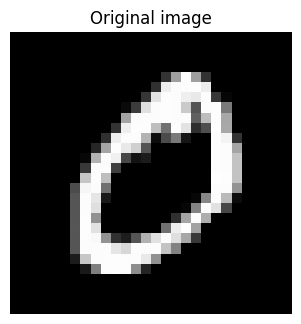

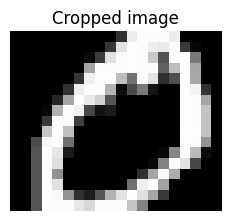

In [ ]:
# Step 8: TODO run this cell to demonstrate the bug.
# DO NOT DELETE THE OUTPUT.
image = X_train[TRAIN_NO]
renderImagePlot(image)

Task 8: If you look at the two images above and the two below, something is definitely wrong.
The cropped images are incorrect. What is the problem? Fix the (Colab) cells
above to resolve the problem.

left:  3 upper:  5 right:  24 lower:  27
Original:
  0123456789012345678901234567 
0 0000000000000000000000000000
1 0000000000000000000000000000
2 0000000000000000000000000000
3 0000000000000000000000000000
4 0000000000000000000000000000
5 0000000000000000000011100000
6 0000110000000000000011100000
7 0000110000000000000111100000
8 0000110000000000000111000000
9 0000110000000000000111000000
0 0001110000000000000111000000
1 0001110000000000001111000000
2 0001110000000000001111000000
3 0001110000000001111110000000
4 0001110001111111111110000000
5 0001111111111111111100000000
6 0000111111110000011100000000
7 0000000000000000011100000000
8 0000000000000000011100000000
9 0000000000000000011100000000
0 0000000000000000011100000000
1 0000000000000000011100000000
2 0000000000000000011100000000
3 0000000000000000011100000000
4 0000000000000000011100000000
5 0000000000000000000000000000
6 0000000000000000000000000000
7 0000000000000000000000000000
Cropped:
  012345678901234567890 
0 0000000000000

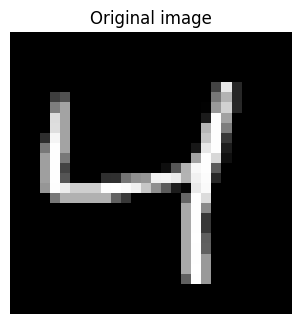

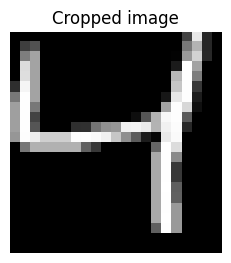

In [53]:
# Step 9A: TODO fix the bug and run this cell to show that the bug has been fixed.
# DO NOT DELETE THE OUTPUT.
TRAIN_NO = 2
image = X_train[TRAIN_NO]
renderImagePlot(image)

left:  8 upper:  5 right:  24 lower:  26
Original:
  0123456789012345678901234567 
0 0000000000000000000000000000
1 0000000000000000000000000000
2 0000000000000000000000000000
3 0000000000000000000000000000
4 0000000000000000000000000000
5 0000000000000000001111000000
6 0000000000000000011111000000
7 0000000000000000011111000000
8 0000000000000000111111000000
9 0000000000000001111100000000
0 0000000000000001111000000000
1 0000000000000011111000000000
2 0000000000000111110000000000
3 0000000000000111110000000000
4 0000000000001111100000000000
5 0000000000011111000000000000
6 0000000000011111000000000000
7 0000000000111110000000000000
8 0000000000111110000000000000
9 0000000000111100000000000000
0 0000000001111100000000000000
1 0000000011111100000000000000
2 0000000011110000000000000000
3 0000000011110000000000000000
4 0000000011110000000000000000
5 0000000000000000000000000000
6 0000000000000000000000000000
7 0000000000000000000000000000
Cropped:
  0123456789012345 
0 0000000000111100
1

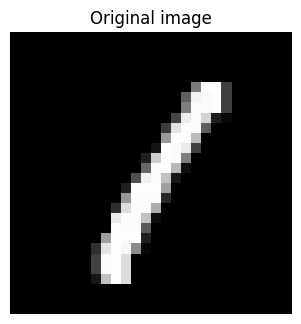

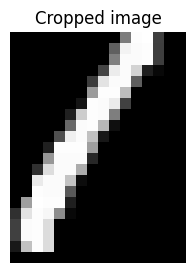

In [59]:
# Step 9B: Experiment with another image to verify the bugs has been fixed.
# DO NOT DELETE THE OUTPUT.
TRAIN_NO = 3
image = X_train[TRAIN_NO]
renderImagePlot(image)

left:  6 upper:  7 right:  26 lower:  27
Original:
  0123456789012345678901234567 
0 0000000000000000000000000000
1 0000000000000000000000000000
2 0000000000000000000000000000
3 0000000000000000000000000000
4 0000000000000000000000000000
5 0000000000000000000000000000
6 0000000000000000000000000000
7 0000000000001111111110000000
8 0000000000011111111110000000
9 0000000001111111111110000000
0 0000000001111100111110000000
1 0000000011111000111100000000
2 0000000111110011111000000000
3 0000001111000111111000000000
4 0000001111111111110000000000
5 0000001111111111100000000000
6 0000000111111111100000000000
7 0000000000000111100000000000
8 0000000000000111100000000000
9 0000000000000011100000000000
0 0000000000000111100000000000
1 0000000000000111100000000000
2 0000000000000111100000000000
3 0000000000000011100000000000
4 0000000000000011110000000000
5 0000000000000011111000000000
6 0000000000000001111000000000
7 0000000000000000000000000000
Cropped:
  01234567890123456789 
0 00000011111111

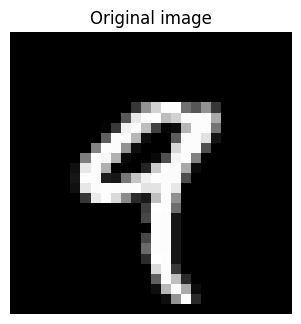

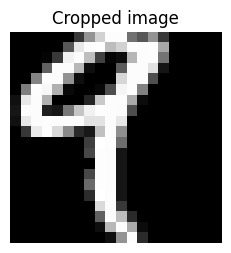

In [62]:
TRAIN_NO = 4
image = X_train[TRAIN_NO]
renderImagePlot(image)

### Bug explanation and resolution
Give a **brief** answers below.
Full credit will only be given for a concise, well-articulated responses.

Regarding the ChatGPT bug, it...

1. Manifests: (what is the effect in the images?) - The top and bottom of the number in the image is cut off for TRAIN_NO = 1 (example with the 0). In other images, the left and right sides get cut off, or sometimes both.
2. Is in: (which step in this Colab?) - It is in step 6A of this Colab.
3. Is caused by this: (which method ChatGPT wrote for this Colab?) - It is in the crop_image method that ChatGPT wrote.
4. Is caused by this: (which statement? Copy and paste the statement here but _only_ if it is just one statement. If it more than one statement, indicate approximately where the problem occurs.) - The problem occurs when calculating the left, right, upper, and lower bounds to crop the image.
5. Occurs because: (why is there this problem?) - This is a problem because it is just using the width of the image, image.shape[1], and the width of the handwritten digit, canvas_width, without taking into account where the first non-zero pixel is in the digit (vice versa for height). The right and bottom bounds are also affected by this problem.
6. Can be repaired if... (how to fix the problem?) - This problem is fixed by using the NumPy method .argwhere(image > 0) to find all the occurences of non-zero pixels. With that returned list of non zero pixels, we then find the min of each column, referring to the left-most and upper-most non-zero pixels. The left-most and upper-most non-zero pixels will be the left and upper bounds. Similarly, the max of each column refers to the right-most and bottom-most pixels. After trial and error of testing different possibilities, it seems that the right bound can just be the right-most non-zero pixel, while the lower bound is the upper bound + the lower-most non-zero pixel. This achieves getting the smallest cropped image without cutting the digit off in any direction.  

## Deliverables

1. Answer the questions in the text cell above. There is no need to create a new text cell, instead, add your answers.
2. Share the copied notebook as viewable only. *Do not remove the outputs.* Copy the link and paste it into the assignment shell.
3. Complete the [submission flight checklist](https://docs.google.com/spreadsheets/u/0/d/1lgCttHGUIbCUTrd0TZIm4Nxfy8wy3jnIvNv7cUPJ-Gw/edit).
When done, export the checklist as lab04-checklist.pdf, and upload it to the assignment shell.